# Chapter 4: Training Models

In [1]:
# to plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Linear Regression

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

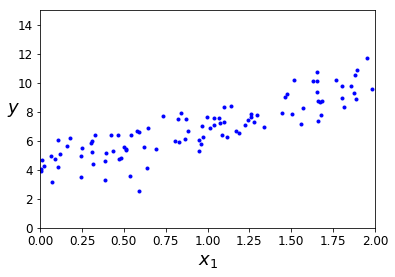

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

### The Normal Equation

The _closed-form solution_ that finds the value of $\theta$ that minimizes the cost function is called the _Normal Equation_:

$$\hat\theta = (\pmb{X}^T \cdot \pmb{X})^{-1} \cdot \pmb{X}^T \cdot \pmb{y}$$

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.11489201],
       [2.89780016]])

Make predictions using the value for $\hat\theta$:

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.11489201],
       [9.91049232]])

Plot the model's predictions:

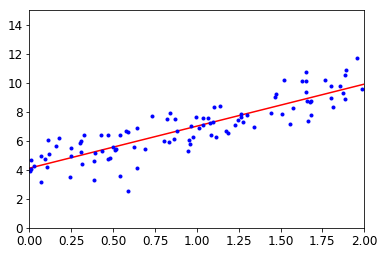

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

The equivalent code using Scikit-Learn:

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.11489201]), array([[2.89780016]]))

In [8]:
lin_reg.predict(X_new)

array([[4.11489201],
       [9.91049232]])

## Gradient Descent

The general idea of _Gradient Descent_ is to tweak parameters iteratively in order to minimize a cost function.

**TIP**: When using Gradient Descent, ensure that all features have a similar scale (e.g. using Scikit-Learn's ``StandardScaler`` class or else it will take much longer to converge.

### Batch Gradient Descent

The _Batch Gradient Descent_ uses the whole batch of training data at every step (i.e. slow on very large training 
sets, however, it scales well with the number of features).

_Gradient vector of the cost function_:
$$\Delta_\theta MSE(\theta) = \frac{2}{m} \pmb{X}^T \cdot (\pmb{X} \cdot \theta - \pmb{y})$$


_Gradient Descent step_:
$$\theta^{next step} = \theta - \eta\Delta_{\theta}MSE(\theta)$$

In [9]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.11489201],
       [2.89780016]])

To find a good learning rate you can use grid search while limiting the number of iterations so that grid search can eliminate models that take too long to converge.

### Stochastic Gradient Descent

_Stochastic Gradient Descent_ picks a random instance in the training set at every step and computes the gradients based only on that single instance.

Randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. A solution to solve this is to gradually reduce the learning rate to allow the algorithm to settle at the global minimum. This process is called _simulated annealing_. The function that determines the learning rate at each iteration is called the _learning schedule_.

In [10]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initilization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[4.08100626],
       [2.90066786]])

The equivalent code in Scikit-Learn:

In [11]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [12]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.10746038]), array([2.89846109]))

### Mini-batch Gradient Descent

_Mini-batch Gradient Descent_ computes the gradients on small random sets of instances called _mini-batches_. It's advantage over SGD is you can get a performance boost from hardware optimization of matrix operations.

### Comparison

| Algorithm | Large _m_ | Out-of-core support | Large _n_ | Hyperparameters | Scaling required | Scikit-Learn |
|-----------|-----------|---------------------|-----------|-----------------|------------------|--------------|
| Normal equation | Fast | No | Slow | 0 | No | `LinearRegression` |
| Batch GD | Slow | No | Fast | 2| Yes | n/a |
| Stochastic GD | Fast | Yes | Fast | ≥2 | Yes | ``SGDRegressor`` |
| Mini-batch GD | Fast | Yes | Fast | ≥2 | Yes | ``SGDRegressor`` |

## Polynomial Regression 

Polynomial Regression is a technique using a linear model to fit nonlinear data. This is done by adding powers of each feature as new features, then training the linear model on the extended set of features.

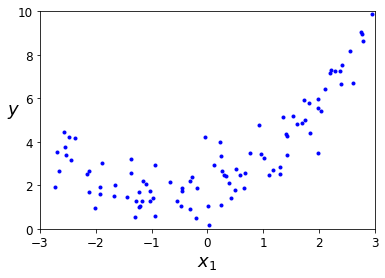

In [13]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1) # actual function

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.11806816])

In [15]:
X_poly[0]

array([0.11806816, 0.01394009])

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.7870507]), array([[0.90594385, 0.58443094]]))

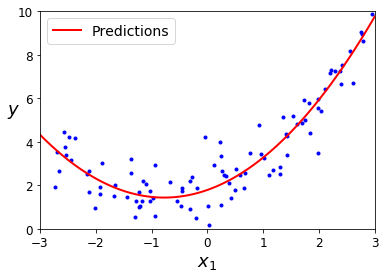

In [17]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning Curves

_Learning curves_ are plots of the model's performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, simply train the model several times on different sized subsets of the training set.

Plot the learning curve for the LinearRegression model:

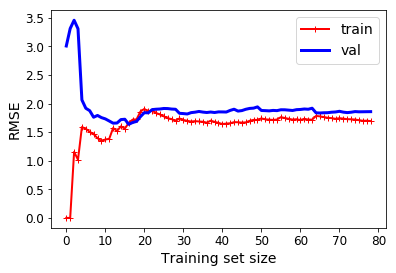

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.

Plot the learning of a $10^{th}$-degree polynomial model:

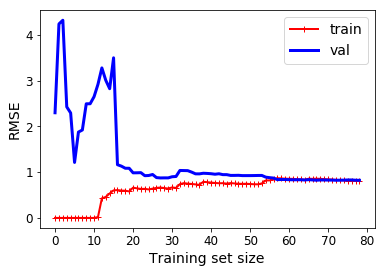

In [30]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

- The error on the training data is much lower than with the Linear Regression model
- There is a gap between the curves. The model works better on the training data which means it is an overfitting model

**TIPS**
- Underfitting: adding more training examples will not help, need to use a more complex model or better features
- Overfititng: feeding more training data until the validation error reaches the training error